In [151]:
# libraries

import seaborn as sns
import xarray as xr
import numpy as np
import pandas as pd
import intake
import dask
import regionmask
import warnings
from pathlib import Path
from tqdm import tqdm
from xmip.preprocessing import combined_preprocessing, replace_x_y_nominal_lat_lon
import matplotlib.pyplot as plt

%matplotlib inline

In [152]:
# data

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
    col = intake.open_esm_datastore(url)

In [153]:
# load some monthly data from the GFDL-CM4 4-K warming experiment

query = dict(experiment_id='amip-p4K',
             variable_id=['ua', 'va'],
             source_id=['GFDL-CM4'],
             table_id='Amon'
            )

cat = col.search(**query)
print(cat.df['source_id'].unique())

# load data into dictionary
# keys are constructed as 'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

z_kwargs = {'consolidated': True, 'decode_times':False}

with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    dset_dict = cat.to_dataset_dict(zarr_kwargs=z_kwargs, preprocess=combined_preprocessing)

# store these on HPCC scratch directory?

['GFDL-CM4']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [154]:
# get a couple datasets out of the dictionary

ds = dset_dict['CFMIP.NOAA-GFDL.GFDL-CM4.amip-p4K.Amon.gr1']
ds

<xarray.Dataset> Size: 3GB
Dimensions:         (member_id: 1, dcpp_init_year: 1, time: 432, plev: 19,
                     y: 180, x: 288, bnds: 2, vertex: 4)
Coordinates: (12/13)
  * y               (y) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * x               (x) float64 2kB 0.625 1.875 3.125 ... 356.9 358.1 359.4
  * plev            (plev) float64 152B 1e+05 9.25e+04 8.5e+04 ... 500.0 100.0
  * time            (time) int64 3kB 0 708 1416 2148 ... 313152 313884 314616
    lat_bounds      (y, bnds, x) float64 829kB dask.array<chunksize=(180, 2, 288), meta=np.ndarray>
    time_bounds     (time, bnds) float64 7kB dask.array<chunksize=(432, 2), meta=np.ndarray>
    ...              ...
    lon             (x, y) float64 415kB 0.625 0.625 0.625 ... 359.4 359.4 359.4
    lat             (x, y) float64 415kB -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
    lon_verticies   (vertex, x, y) float64 2MB dask.array<chunksize=(1, 288, 180), meta=np.ndarray>
    lat_verticies   (vertex, x, y) float64 2MB dask.array<chunksize=(1, 288, 180), meta=np.ndarray>
  * member_id       (member_id) object 8B 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 8B nan
Dimensions without coordinates: bnds, vertex
Data variables:
    ua              (member_id, dcpp_init_year, time, plev, y, x) float32 2GB dask.array<chunksize=(1, 1, 38, 19, 180, 288), meta=np.ndarray>
    va              (member_id, dcpp_init_year, time, plev, y, x) float32 2GB dask.array<chunksize=(1, 1, 35, 19, 180, 288), meta=np.ndarray>
Attributes: (12/53)
    Conventions:                      CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:                      CFMIP
    branch_method:                    none provided
    branch_time_in_child:             0.0
    comment:                          <null ref>
    contact:                          gfdl.climate.model.info@noaa.gov
    ...                               ...
    intake_esm_attrs:member_id:       r1i1p1f1
    intake_esm_attrs:table_id:        Amon
    intake_esm_attrs:grid_label:      gr1
    intake_esm_attrs:version:         20180701
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CFMIP.NOAA-GFDL.GFDL-CM4.amip-p4K.Amon.gr1

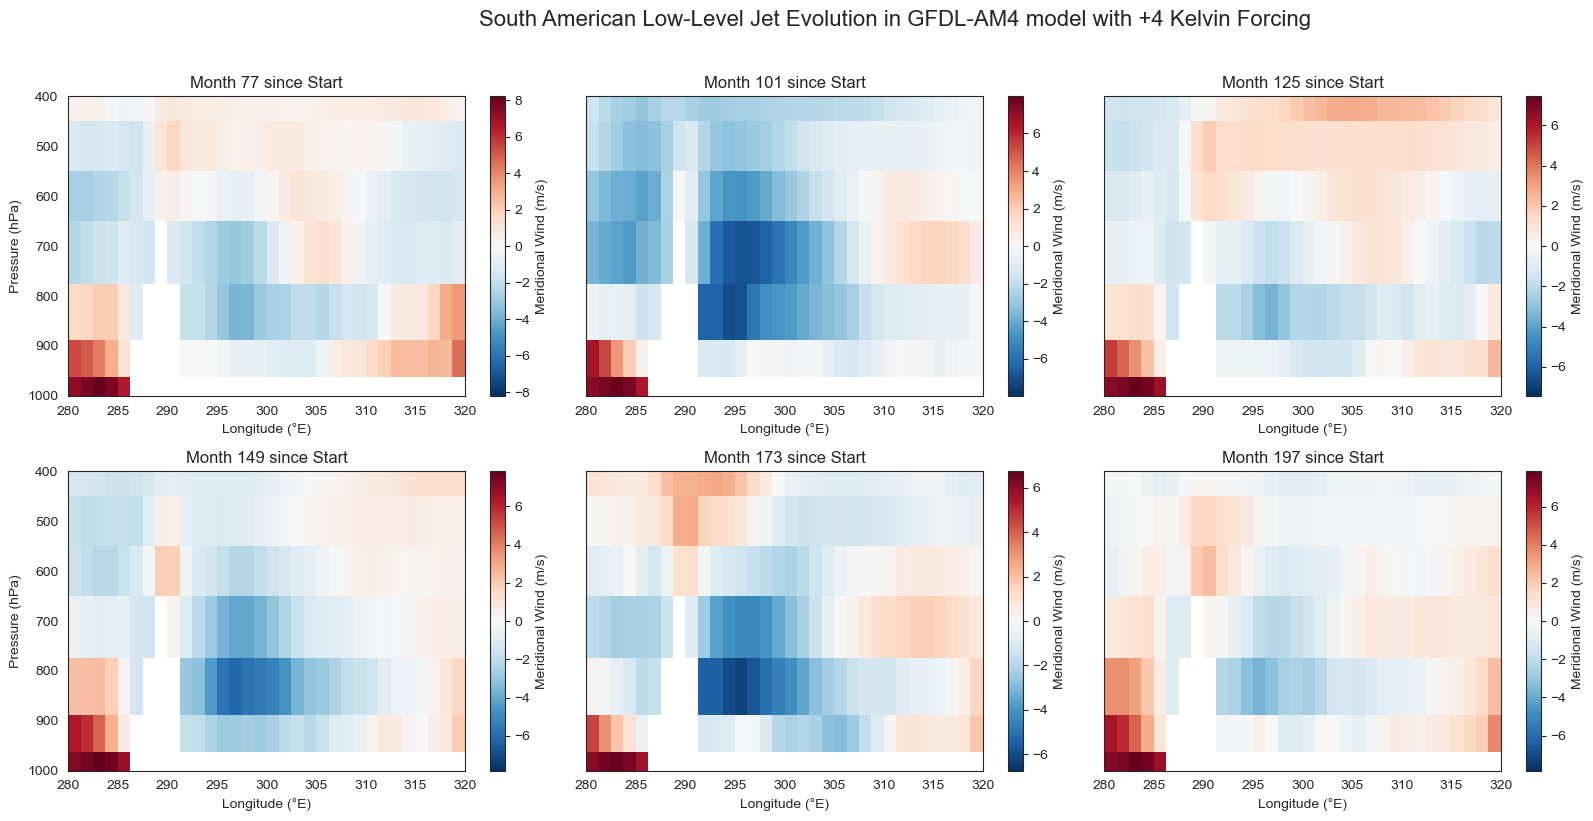

In [156]:
# test plot six instances (avg meridional wind in june of year 6, 8, 10, 12, 14, 16)
regional1 = ds.sel(x=slice(280, 320), y=-15.5).isel(time=77).assign_coords(plev=ds['plev'] / 100)
regional2 = ds.sel(x=slice(280, 320), y=-15.5).isel(time=101).assign_coords(plev=ds['plev'] / 100)
regional3 = ds.sel(x=slice(280, 320), y=-15.5).isel(time=125).assign_coords(plev=ds['plev'] / 100)
regional4 = ds.sel(x=slice(280, 320), y=-15.5).isel(time=149).assign_coords(plev=ds['plev'] / 100)
regional5 = ds.sel(x=slice(280, 320), y=-15.5).isel(time=173).assign_coords(plev=ds['plev'] / 100)
regional6 = ds.sel(x=slice(280, 320), y=-15.5).isel(time=197).assign_coords(plev=ds['plev'] / 100)

# plot setup
sns.set_style('white')
regionals = [regional1, regional2, regional3, regional4, regional5, regional6]
titles = [f'Month {i} since Start' for i in [77, 101, 125, 149, 173, 197]]

# create 2x3 subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 8), sharey=True)

# flatten axes for easy looping
axes = axes.flatten()

# loop through and plot
for i, ax in enumerate(axes):
    regionals[i]['va'].plot(ax=ax, y='plev', add_colorbar=True).colorbar.set_label('Meridional Wind (m/s)')
    ax.set_ylim(1000, 400)
    ax.set_title(titles[i])
    ax.set_xlabel('Longitude (°E)')
    if i % 3 == 0:
        ax.set_ylabel('Pressure (hPa)')
    else:
        ax.set_ylabel('')

# adjust layout
plt.suptitle('South American Low-Level Jet Evolution in GFDL-AM4 model with +4 Kelvin Forcing', fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()